In [13]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,BatchNormalization,Cropping2D
from tensorflow.keras.models import Model
import random
import tensorflow as tf

In [14]:
# Đọc tệp Excel vào DataFrame
file_path = "/kaggle/input/dataset/data/classification.xlsx"  # Đường dẫn đến file Excel
df = pd.read_excel(file_path)

# Đường dẫn thư mục ảnh và mask
image_path = '/kaggle/input/dataset/data/images'
mask_path = '/kaggle/input/dataset/data/masks'
print("a1")

a1


In [15]:
# Lọc những ảnh có mask
df_with_mask = df[df['mask_flag'] == 1]

# Chia train, test, valid
df_train = df_with_mask[df_with_mask['tumor_category'] == 1].copy()
df_test  = df_with_mask[df_with_mask['tumor_category'] == 2].copy()
df_valid = df_with_mask[df_with_mask['tumor_category'] == 3].copy()
print("a1")

a1


In [16]:
# Tạo cột đường dẫn
df_train['image_path'] = df_train['image_id'].apply(lambda x: os.path.join(image_path, f"{os.path.splitext(x)[0]}.jpg"))
df_train['mask_path']  = df_train['image_id'].apply(lambda x: os.path.join(mask_path, f"{os.path.splitext(x)[0]}.png"))

df_test['image_path'] = df_test['image_id'].apply(lambda x: os.path.join(image_path, f"{os.path.splitext(x)[0]}.jpg"))
df_test['mask_path']  = df_test['image_id'].apply(lambda x: os.path.join(mask_path, f"{os.path.splitext(x)[0]}.png"))

df_valid['image_path'] = df_valid['image_id'].apply(lambda x: os.path.join(image_path, f"{os.path.splitext(x)[0]}.jpg"))
df_valid['mask_path']  = df_valid['image_id'].apply(lambda x: os.path.join(mask_path, f"{os.path.splitext(x)[0]}.png"))

print("a1")

a1


In [17]:
# Hàm load ảnh và mask
def load_image_and_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    
    image = tf.image.resize(image, (224, 224))
    mask = tf.image.resize(mask, (224, 224))
    return image, mask

# Chọn batch size random trước
BATCH_SIZE = random.choice([8])
if not df_train.empty:
    train_dataset = tf.data.Dataset.from_tensor_slices((df_train['image_path'], df_train['mask_path']))
    train_dataset = train_dataset.map(load_image_and_mask)
    train_dataset = train_dataset.shuffle(buffer_size=1000)
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
else:
    print("⚠️ df_train is empty. Skipping train_dataset creation.")
    train_dataset = None

# Tạo datasets
train_dataset = tf.data.Dataset.from_tensor_slices((df_train['image_path'], df_train['mask_path']))
train_dataset = train_dataset.map(load_image_and_mask)
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((df_valid['image_path'], df_valid['mask_path']))
val_dataset = val_dataset.map(load_image_and_mask)
val_dataset = val_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((df_test['image_path'], df_test['mask_path']))
test_dataset = test_dataset.map(load_image_and_mask)
test_dataset = test_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
print("a1")

a1


Train batch shape:
Image batch shape: (8, 224, 224, 1)
Mask batch shape: (8, 224, 224, 1)


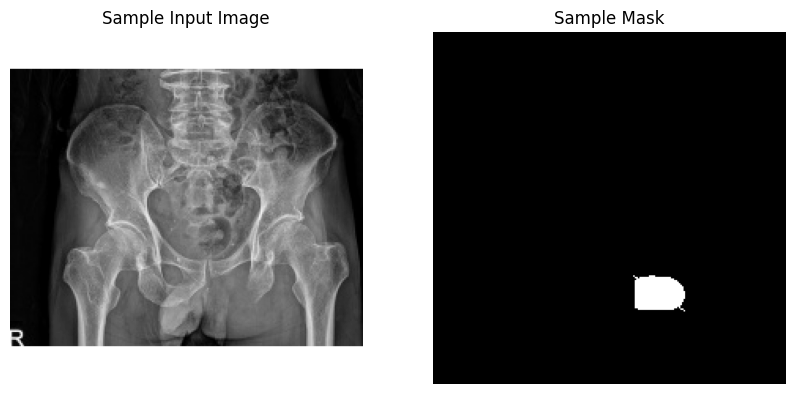

Validation batch shape:
Image batch shape: (16, 224, 224, 1)
Mask batch shape: (16, 224, 224, 1)


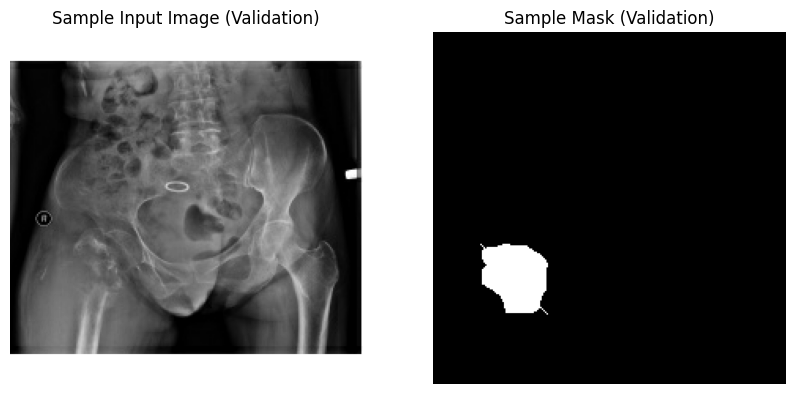

Test batch shape:
Image batch shape: (16, 224, 224, 1)
Mask batch shape: (16, 224, 224, 1)


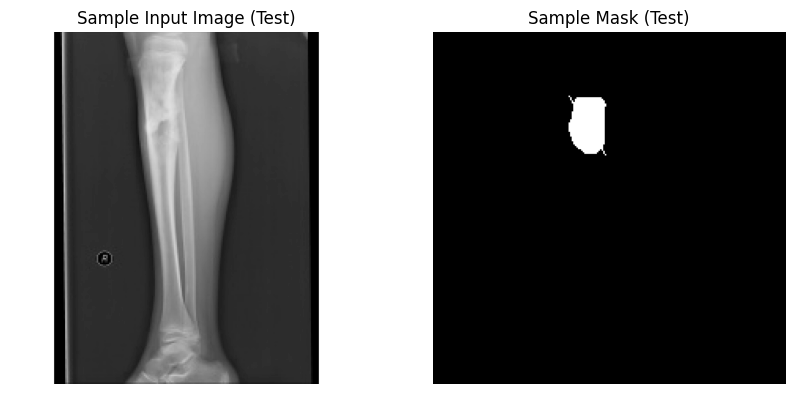

a1


In [18]:
import matplotlib.pyplot as plt

# Kiểm tra một batch từ train_dataset
for images, masks in train_dataset.take(1):  # Lấy 1 batch từ train_dataset
    print("Train batch shape:")
    print("Image batch shape:", images.shape)  # Kích thước của batch ảnh
    print("Mask batch shape:", masks.shape)    # Kích thước của batch mask

    # Hiển thị một ảnh và mask
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(images[0, :, :, 0], cmap='gray')  # Hiển thị ảnh đầu tiên trong batch (1 channel)
    plt.title("Sample Input Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[0, :, :, 0], cmap='gray')  # Hiển thị mask đầu tiên trong batch (1 channel)
    plt.title("Sample Mask")
    plt.axis('off')

    plt.show()
    break  # Dừng sau khi đã kiểm tra 1 batch

# Kiểm tra một batch từ val_dataset
for images, masks in val_dataset.take(1):
    print("Validation batch shape:")
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(images[0, :, :, 0], cmap='gray')
    plt.title("Sample Input Image (Validation)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[0, :, :, 0], cmap='gray')
    plt.title("Sample Mask (Validation)")
    plt.axis('off')

    plt.show()
    break

# Kiểm tra một batch từ test_dataset
for images, masks in test_dataset.take(1):
    print("Test batch shape:")
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(images[0, :, :, 0], cmap='gray')
    plt.title("Sample Input Image (Test)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[0, :, :, 0], cmap='gray')
    plt.title("Sample Mask (Test)")
    plt.axis('off')

    plt.show()
    break
print("a1")

In [19]:
# Hàm 2 lớp conv + batchnorm + relu
def conv_block(x, filters):
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

# Khối Attention
def attention_block(x, g, filters):
    theta_x = layers.Conv2D(filters, (1, 1))(x)
    phi_g = layers.Conv2D(filters, (1, 1))(g)

    add = layers.Add()([theta_x, phi_g])
    act = layers.Activation('relu')(add)
    psi = layers.Conv2D(1, (1, 1))(act)
    psi = layers.Activation('sigmoid')(psi)

    att = layers.Multiply()([x, psi])
    return att

# Khối encoder: conv -> dropout -> pooling
def encoder_block(x, filters, dropout_rate=0.3):
    conv = conv_block(x, filters)
    conv = layers.Dropout(dropout_rate)(conv)
    pool = layers.MaxPooling2D((2, 2))(conv)
    return conv, pool

# Khối decoder: upsampling -> attention -> concat -> conv
def decoder_block(x, skip, filters):
    up = layers.UpSampling2D((2, 2))(x)
    up = layers.Conv2D(filters, (2, 2), activation='relu', padding='same')(up)

    attn = attention_block(skip, up, filters)

    merge = layers.concatenate([up, attn])
    conv = conv_block(merge, filters)
    return conv

# Xây dựng mô hình UNet + Attention
def unet_attention(input_shape=(224, 224, 1), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b1 = conv_block(p4, 1024)
    b1 = layers.Dropout(0.3)(b1)
    b1 = conv_block(b1, 1024)
    b1 = layers.Dropout(0.3)(b1)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output layer
    if num_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = layers.Conv2D(num_classes, (1, 1), activation=activation)(d4)

    model = models.Model(inputs, outputs)
    return model

# Khởi tạo mô hình
model = unet_attention(input_shape=(224, 224, 1), num_classes=1)

# Compile
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.MeanIoU(num_classes=2)
    ]
)

# Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 224, 224, 64)   │            640 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 224, 224, 64)   │            256 │ conv2d_37[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_28             │ (None, 224, 224, 64)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 224, 224, 64)   │         36,928 │ activation_28[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 224, 224, 64)   │            256 │ conv2d_38[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_29             │ (None, 224, 224, 64)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 224, 224, 64)   │              0 │ activation_29[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 112, 112, 64)   │              0 │ dropout_6[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 112, 112, 128)  │            512 │ conv2d_39[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_30             │ (None, 112, 112, 128)  │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 112, 112, 128)  │        147,584 │ activation_30[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 112, 112, 128)  │            512 │ conv2d_40[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_31             │ (None, 112, 112, 128)  │              0 │ batch_normalization_2… │
│ (Activation)         

 Total params: 50,637,957 (193.17 MB)

 Trainable params: 50,622,085 (193.11 MB)

 Non-trainable params: 15,872 (62.00 KB)

In [20]:

epochs = 300

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    verbose=1
)

print("✅ Quá trình huấn luyện hoàn tất!")


Epoch 1/300


I0000 00:00:1749184263.830234      98 service.cc:148] XLA service 0x7f5e08002a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749184263.830899      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749184266.387728      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749184297.812995      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


164/165 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9499 - loss: 0.2119 - mean_io_u_1: 0.4910 - precision_1: 0.0214 - recall_1: 0.0413

E0000 00:00:1749184346.845005      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749184347.077640      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749184347.774525      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749184348.008200      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


165/165 ━━━━━━━━━━━━━━━━━━━━ 148s 530ms/step - accuracy: 0.9502 - loss: 0.2110 - mean_io_u_1: 0.4910 - precision_1: 0.0214 - recall_1: 0.0409 - val_accuracy: 0.9824 - val_loss: 0.2236 - val_mean_io_u_1: 0.4912 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/300
165/165 ━━━━━━━━━━━━━━━━━━━━ 45s 267ms/step - accuracy: 0.9824 - loss: 0.0772 - mean_io_u_1: 0.4912 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9824 - val_loss: 0.1217 - val_mean_io_u_1: 0.4912 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/300
165/165 ━━━━━━━━━━━━━━━━━━━━ 45s 267ms/step - accuracy: 0.9822 - loss: 0.0732 - mean_io_u_1: 0.4911 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9824 - val_loss: 0.0957 - val_mean_io_u_1: 0.4912 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/300
165/165 ━━━━━━━━━━━━━━━━━━━━ 45s 267ms/step - accuracy: 0.9824 - loss: 0.0708 - mean_io_u_1: 0.4912 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 

In [21]:
results = model.evaluate(test_dataset)
print(f"Results: {results}")

23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9822 - loss: 0.2447 - mean_io_u_1: 0.4909 - precision_1: 0.6875 - recall_1: 0.0486

E0000 00:00:1749198548.521935      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749198548.755352      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 465ms/step - accuracy: 0.9822 - loss: 0.2438 - mean_io_u_1: 0.4910 - precision_1: 0.6915 - recall_1: 0.0493
Results: [0.23409505188465118, 0.9831932783126831, 0.7371822595596313, 0.05664603039622307, 0.4913485050201416]


In [ ]:
model.save('n1.h5')
model.save('/kaggle/working//n1.h5') 